# LAB5 QIC

In [99]:
!pip install qiskit qiskit-aer qiskit-terra seaborn numpy matplotlib pip install qiskit-ibmq-provider

In [100]:
import qiskit.tools.jupyter
%qiskit_version_table

In [101]:
from qiskit import IBMQ, Aer, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, assemble
from qiskit.visualization import plot_histogram, plot_bloch_vector,plot_bloch_multivector
from qiskit import IBMQ
import math
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
import numpy as np

## Superdense Coding

Superdense Coding and Quantum Teleportation are closely related. Quantum teleportation is the process in which the state of the qubit $\ket{\psi}$ can be transmitted from one location to another, using two bits of classical communication and a Bell pair. It's a protocol that destroys the quantum state of a qubit in one location and recreates it on a qubit at a distant location, with the help of shared entanglement. Superdense coding, on the other hand, is a procedure to send two classical bits to another location using just a single qubit of communication.

### The procedure

#### Step 1

The process is started by a third party, Charlie. Two qubits are prepared by Charlie in an entangled state. He initially starts the 2 qubits in the basis state $\ket{0}$, on which he apply the Hadamard gate on the first qubit and CNOT gate (first qubit is the control qubit). 

$\ket{00} = \ket{0}_A \otimes \ket{0}_B$

After applying the H gate we obtain the state:

$$
\ket{+0}=\frac{1}{\sqrt{2}}\left(\ket{00}+\ket{10}\right)
$$

After applying the CNOT gate results the state:

$$
CNOT: \frac{1}{\sqrt{2}}\left(\ket{00}+\ket{10}\right) \rightarrow \frac{1}{\sqrt{2}}\left(\ket{00}+\ket{11}\right)
$$

#### Step 2

Charlie sends the first qubit to Alice and the second qubit to Bob. The goal is for Alice to send 2 classical bits of information to Bob using her qubit. But before she does, she needs to apply a set of quantum gates to her qubit depending on the 2 bits of information she wants to send

| Intended Message | Applied Gate | Resulting State ($ \frac{1}{\sqrt{2}}$) |
|------------------|--------------|---------------------------------------------|
| 00               | I            | $\ket{00}+\ket{11}$                         |
| 01               | X            | $\ket{10}+\ket{01}$                         |
| 10               | Z            | $\ket{00}-\ket{11}$                         |
| 11               | ZX           | $-\ket{10}+\ket{01}$                        |

#### Step 3

Bob receives Alice's qubit and uses his qubit to decode Alice's message. Bob applies CNOT gate using leftmost qubit as control and rightmost as target. Then he applies H gate and finally performs a measurement on both qubits to extract Alice's message.

| Bob Receives ($ \frac{1}{\sqrt{2}}$)        | After CNOT gate ($ \frac{1}{\sqrt{2}}$) | After H-gate |
|---------------------------------------------|-----------------------------------------|--------------|
| $\ket{00}+\ket{11}$                         | $\ket{00}+\ket{01}$                     | $\ket{00}$   |
| $\ket{10}+\ket{01}$                         | $\ket{11}+\ket{01}$                     | $\ket{01}$   |
| $\ket{00}-\ket{11}$                         | $\ket{00}-\ket{10}$                     | $\ket{10}$   |
| $-\ket{10}+\ket{01}$                        | $-\ket{11}+\ket{01}$                    | $\ket{11}$   |

### Qiskit Implementation

In [104]:
# function to create a bell pair
def create_bell_pair():
    """
    Returns:
        QuantumCircuit: Circuit that produces a Bell pair
    """
    qc = QuantumCircuit(2)
    qc.h(1)
    qc.cx(1,0)
    return qc

In [105]:
# function to encode message
def encode_message(qc, qubit, msg):
    """Encodes a two-bit message on qc using the superdense coding protocol
    Args:
        qc (QuantumCircuit): Circuit to encode message on
        qubit (int): Which qubit to add the gate to
        msg (str): Two-bit message to send
    Returns:
        QuantumCircuit: Circuit that, when decoded, will produce msg
    Raises:
        ValueError if msg is wrong length or contains invalid characters
    """
    if len(msg) != 2 or not set(msg).issubset({"0","1"}):
        raise ValueError(f"message '{msg}' is invalid")
    if msg[1] == "1":
        qc.x(qubit)
    if msg[0] == "1":
        qc.z(qubit)
    return qc
    

In [106]:
# function to decode message
def decode_message(qc):
    qc.cx(1, 0)
    qc.h(1)
    return qc

In [107]:
# Step 1, Charlie creates the Bell pair
qc = create_bell_pair()

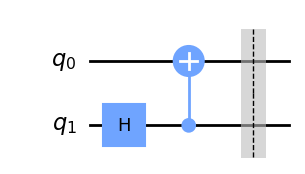

In [108]:
qc.barrier()
qc.draw(output = "mpl")

In [110]:
# Qubit 0 goes to Alice and 1 goes to Bob
# Alice encodes her message on 1 qubit.
message = "10"
qc = encode_message(qc, 1, message)

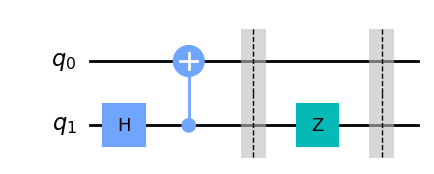

In [111]:
qc.barrier()
qc.draw(output = "mpl")

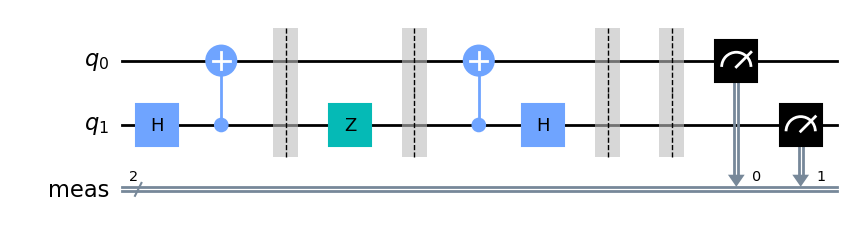

In [112]:
# Alice send her qubit to Bob.
# Bob applies the recovery protocol:
qc = decode_message(qc)
qc.barrier()
qc.measure_all()
qc.draw(output = "mpl")

{'10': 1024}


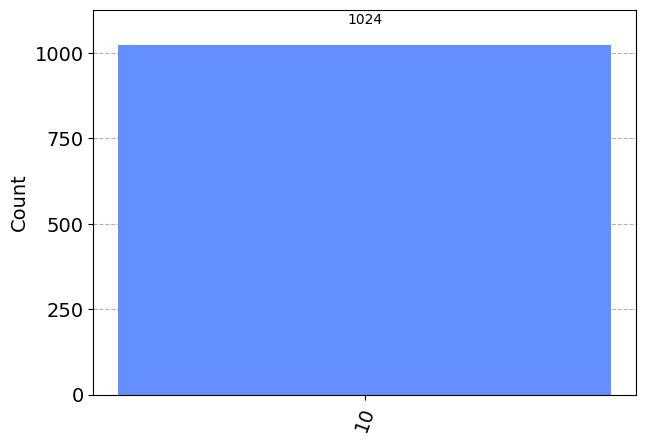

In [113]:
aer_sim = Aer.get_backend('aer_simulator')
result = aer_sim.run(qc).result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts)

In [118]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to nqubits
IBMQ.save_account("542beb7f449ff1730b75e73507e0436ddb63c5f926222405d98077a734d14d0fb876de94d1edb8f9a550e64f4b9f4af656c312325014fe4ec568bfc52442546a")
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

configrc.store_credentials:WARNING:2023-11-17 12:12:50,190: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2023-11-17 12:12:50,506: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibm_nairobi


In [119]:
t_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(t_qc)

In [ ]:
# Monitoring our job
from qiskit.tools.monitor import job_monitor
job_monitor(job)

In [ ]:
# Plotting our result
result = job.result()
plot_histogram(result.get_counts(qc))

In [ ]:
correct_results = result.get_counts(qc)[message]
accuracy = (correct_results/shots)*100
print(f"Accuracy = {accuracy:.2f}%")